# Household Accessiblity Analysis
Machine learning project to classify households by accessibility levels using geospatial, environmental, and distance-based features. Useful for infrastructure planning and rural service delivery.

In [46]:
# reading data on google drive
from google.colab import drive
# Mount your Google Drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

# Load CSV file from Google Drive
file_path = '/content/drive/MyDrive/other/data/Data for MSC Thesis/eth_householdgeovariables_y5.csv'
df = pd.read_csv(file_path)

print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.4   
1  20101010100104022        7.7   162.300003    82.900002             0.4   
2  20101010100104033        7.7   162.300003    82.900002             0.4   
3  20101010100104044        7.7   162.300003    82.900002             0.4   
4  20101010100104055        7.7   162.300003    82.900002             0.4   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   
2         0.0         283         307          184           47  ...   
3         0.0         283         307          184           47  ...   
4         0.0         283         307          1

In [47]:
# ------------------------------
# DATA EXPLORATION: NULL AND OUTLIER PERCENTAGE
# ------------------------------

# ------------------------------
# Step 1: Dataset Overview
# ------------------------------
print("----- Dataset Info -----")
print(df.info())

print("\n----- Dataset Shape -----")
print(df.shape)

print("\n----- Statistical Summary -----")
print(df.describe())

# ------------------------------
# Step 2: Missing Values by Percentage
# ------------------------------
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("\n----- Missing Values Summary -----")
print(missing_df.sort_values(by='Percentage', ascending=False))

# ------------------------------
# Step 3: Outlier Detection by Percentage (Numeric Columns Only)
# ------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

outlier_summary = []
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(df)) * 100

    outlier_summary.append([col, outlier_count, outlier_percent])

outlier_df = pd.DataFrame(outlier_summary, columns=['Column', 'Outlier Count', 'Outlier %'])
print("\n----- Outlier Summary by Percentage -----")
print(outlier_df.sort_values(by='Outlier %', ascending=False))

----- Dataset Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   household_id       4890 non-null   int64  
 1   dist_road          4890 non-null   float64
 2   dist_market        4890 non-null   float64
 3   dist_border        4890 non-null   float64
 4   dist_popcenter     4890 non-null   float64
 5   dist_admhq         4890 non-null   float64
 6   af_bio_1_x         4890 non-null   int64  
 7   af_bio_8_x         4890 non-null   int64  
 8   af_bio_12_x        4890 non-null   int64  
 9   af_bio_13_x        4890 non-null   int64  
 10  af_bio_16_x        4890 non-null   int64  
 11  afmnslp_pct        4890 non-null   int64  
 12  srtm_1k            4890 non-null   int64  
 13  popdensity         4890 non-null   int64  
 14  cropshare          4890 non-null   int64  
 15  sq1                4890 non-null   int64  
 16 

In [48]:
# check number of distinic catagory
for col in ['ssa_aez09', 'landcov']:
    print(f"\nColumn: {col}")
    print("Number of distinct categories:", df[col].nunique())
    print("Categories:", df[col].unique())


Column: ssa_aez09
Number of distinct categories: 7
Categories: ['Tropic-warm/semiarid' 'Tropic-warm/arid' 'Tropic-cool/subhumid'
 'Tropic-cool/semiarid' 'Tropic-cool/humid' 'Tropic-cool/arid'
 'Tropic-warm/subhumid']

Column: landcov
Number of distinct categories: 9
Categories: ['Bare/sparse vegetation' 'Cropland' 'Built-up' 'Shrubs'
 'Herbaceous vegetation' 'Open forest unknown'
 'Closed forest deciduous broad leaf' 'Closed forest evergreen broad leaf'
 'Open forest deciduous broad leaf']


In [49]:
#----------------------------------------
#1 Drop columns with more than 40% missing
#----------------------------------------
missing_threshold = 0.4
cols_to_drop = df.columns[df.isnull().mean() > missing_threshold]

print("Dropping columns:", cols_to_drop.tolist())
df = df.drop(columns=cols_to_drop)

# 2. Remove spatial leakage
#df = df.drop(columns=['lat_dd_mod', 'lon_dd_mod'], errors='ignore')

# 3. Winsorize numeric features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in num_cols:
    if col not in ['household_id', 'AI_pca1']:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)

Dropping columns: ['c2_eviarea_avg', 'c2_evimax_avg', 'c2_grn_avg', 'c2_sen_avg', 'c2_h2021_eviarea', 'c2_h2021_evimax', 'c2_h2021_grn', 'c2_h2021_sen']


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   household_id       4890 non-null   int64  
 1   dist_road          4890 non-null   float64
 2   dist_market        4890 non-null   float64
 3   dist_border        4890 non-null   float64
 4   dist_popcenter     4890 non-null   float64
 5   dist_admhq         4890 non-null   float64
 6   af_bio_1_x         4890 non-null   int64  
 7   af_bio_8_x         4890 non-null   int64  
 8   af_bio_12_x        4890 non-null   int64  
 9   af_bio_13_x        4890 non-null   int64  
 10  af_bio_16_x        4890 non-null   int64  
 11  afmnslp_pct        4890 non-null   int64  
 12  srtm_1k            4890 non-null   int64  
 13  popdensity         4890 non-null   int64  
 14  cropshare          4890 non-null   int64  
 15  sq1                4890 non-null   int64  
 16  sq2                4890 

In [51]:
# ==============================
# 2. Check columns
# ==============================
print("Before Encoding:")
print(df[['ssa_aez09','landcov']].head())

# ==============================
# 4. One-Hot Encode categorical columns
# ==============================
df_encoded = pd.get_dummies(
    df,
    columns=['ssa_aez09', 'landcov'],
    drop_first=True   # avoids multicollinearity (important for regression)
)

# ==============================
# 5. View results
# ==============================
print("\nAfter Encoding:")
print(df_encoded.head())

print("\nNew columns created:")
new_cols = [col for col in df_encoded.columns if 'ssa_aez09_' in col or 'landcov_' in col]
print(new_cols)

# ==============================
# 6. Check dataset shape
# ==============================
print("\nOriginal shape:", df.shape)
print("Encoded shape:", df_encoded.shape)

# change to boolean to numerical value
#bool_cols = df_encoded.select_dtypes(include='bool').columns
#df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
df=df_encoded.copy()

Before Encoding:
              ssa_aez09                 landcov
0  Tropic-warm/semiarid  Bare/sparse vegetation
1  Tropic-warm/semiarid  Bare/sparse vegetation
2  Tropic-warm/semiarid  Bare/sparse vegetation
3  Tropic-warm/semiarid  Bare/sparse vegetation
4  Tropic-warm/semiarid  Bare/sparse vegetation

After Encoding:
        household_id  dist_road  dist_market  dist_border  dist_popcenter  \
0  20101010100104011        7.7   162.300003    82.900002             0.5   
1  20101010100104022        7.7   162.300003    82.900002             0.5   
2  20101010100104033        7.7   162.300003    82.900002             0.5   
3  20101010100104044        7.7   162.300003    82.900002             0.5   
4  20101010100104055        7.7   162.300003    82.900002             0.5   

   dist_admhq  af_bio_1_x  af_bio_8_x  af_bio_12_x  af_bio_13_x  ...  \
0         0.0         283         307          184           47  ...   
1         0.0         283         307          184           47  ...   

🔧 UPDATED DATA PREPROCESSING WITH ACCESSIBILITY INDEX

1. CREATING ACCESSIBILITY INDEX (TARGET)
--------------------------------------------------
AI_pca1 created ✓  Range: -1.593 to 6.880
Accessibility Classes: {'Low': 1652, 'High': 1628, 'Medium': 1610}
✅ Target variables created successfully!


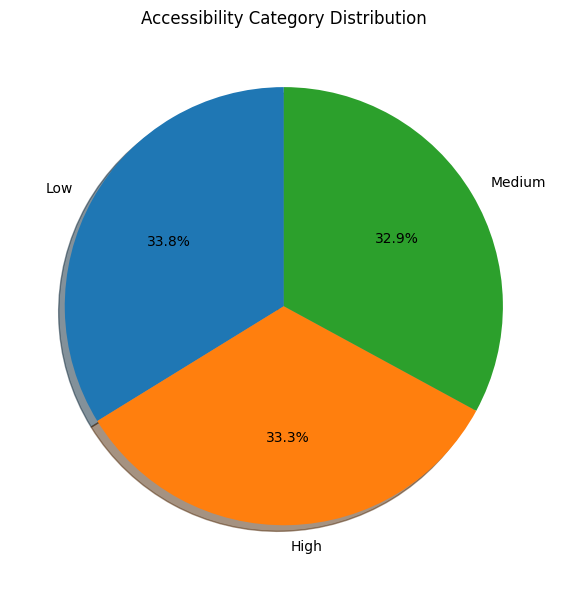

In [52]:
# =============================================================================
# CELL 1: COMPREHENSIVE DATA PREPROCESSING (UPDATED WITH AI + CLASS TARGET)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("🔧 UPDATED DATA PREPROCESSING WITH ACCESSIBILITY INDEX")
print("=" * 60)

# =============================================================================
# 1. CREATE TARGET VARIABLE: ACCESSIBILITY INDEX (TARGET)
# =============================================================================
print("\n1. CREATING ACCESSIBILITY INDEX (TARGET)")
print("-" * 50)

# 5 distance columns (required for AI)
dist_cols = ['dist_road', 'dist_market', 'dist_popcenter',
             'dist_border', 'dist_admhq']

# --- Standardize distance variables ---
scaler_ai = StandardScaler()
Z = scaler_ai.fit_transform(df[dist_cols])

# --- PCA to compute Accessibility Index ---
pca = PCA(n_components=1)
df['AI_pca1'] = pca.fit_transform(Z)[:, 0]  # continuous target

print(f"AI_pca1 created ✓  Range: {df['AI_pca1'].min():.3f} to {df['AI_pca1'].max():.3f}")

# ------------------------------
# Create 3-class Accessibility Category
# ------------------------------
q33 = df['AI_pca1'].quantile(0.33)
q66 = df['AI_pca1'].quantile(0.66)

def classify_access(x):
    if x <= q33:
        return "High"       # best access
    elif x <= q66:
        return "Medium"
    else:
        return "Low"        # worst access

df['accessibility_category'] = df['AI_pca1'].apply(classify_access)

print("Accessibility Classes:", df['accessibility_category'].value_counts().to_dict())
print("✅ Target variables created successfully!")

# =============================================================================
# VISUALIZATION
# =============================================================================

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(7, 6))

# Pie chart of accessibility categories
df['accessibility_category'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    ax=axes,
    startangle=90,
    shadow=True
)

axes.set_ylabel("")  # remove default label
axes.set_title("Accessibility Category Distribution")

plt.tight_layout()
plt.show()

In [53]:
# ==========================================================
# STEP 1: SELECT VARIABLES FOR RISK INDEX
# ==========================================================

risk_vars = [
    'dist_road',      # remoteness
    'dist_market',    # service access
    'afmnslp_pct',  # slop or terrain difficulty
    'popdensity',  # service pressure
    'pct_urban_center'     # rural isolation indicator
]

# keep only available columns
risk_vars = [col for col in risk_vars if col in df.columns]

print("Variables used:", risk_vars)

# ==========================================================
# STEP 2: NORMALIZE (0–1 SCALE)
# ==========================================================

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

norm_data = scaler.fit_transform(df[risk_vars])
norm_df = pd.DataFrame(norm_data, columns=[v + "_norm" for v in risk_vars])

df = pd.concat([df, norm_df], axis=1)

print("Normalization complete ✓")

# ==========================================================
# STEP 3: ACCESSIBILITY RISK SCORE
# ==========================================================

df['Accessibility_Risk'] = (
    0.35 * df['dist_road_norm'] +
    0.25 * df['dist_market_norm'] +
    0.20 * df['afmnslp_pct_norm'] +
    0.20 * (1 - df['pct_urban_center'])   # less urban = higher risk
)

print("Risk score created ✓")
df['Accessibility_Risk'].describe()

# ==========================================================
# STEP 4: CLASSIFY RISK LEVELS
# ==========================================================

q1 = df['Accessibility_Risk'].quantile(0.33)
q2 = df['Accessibility_Risk'].quantile(0.66)

def classify_risk(x):
    if x <= q1:
        return "Low Risk"
    elif x <= q2:
        return "Moderate Risk"
    else:
        return "High Risk"

df['Risk_Class'] = df['Accessibility_Risk'].apply(classify_risk)

print(df['Risk_Class'].value_counts())

Variables used: ['dist_road', 'dist_market', 'afmnslp_pct', 'popdensity', 'pct_urban_center']
Normalization complete ✓
Risk score created ✓
Risk_Class
High Risk        1654
Low Risk         1623
Moderate Risk    1613
Name: count, dtype: int64


In [59]:
# ------------------------------
# FULL PREPROCESSING PIPELINE WITH SMOTE (NO WARNINGS)
# ------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# ------------------------------
# Step 1: Drop irrelevant/correlated columns
# ------------------------------

cols_to_drop = [
    'household_id','dist_road',
    'dist_market','dist_border',
    'dist_popcenter','Accessibility_Risk',
    'dist_admhq','suppress','dst_road_norm',
    'dist_market_norm','afmnslp_pct_norm',
    'popdensity_norm','pct_urban_center_norm'
]

df = df.drop(columns=cols_to_drop, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   af_bio_1_x                                  4890 non-null   int64  
 1   af_bio_8_x                                  4890 non-null   int64  
 2   af_bio_12_x                                 4890 non-null   int64  
 3   af_bio_13_x                                 4890 non-null   int64  
 4   af_bio_16_x                                 4890 non-null   int64  
 5   afmnslp_pct                                 4890 non-null   int64  
 6   srtm_1k                                     4890 non-null   int64  
 7   popdensity                                  4890 non-null   int64  
 8   cropshare                                   4890 non-null   int64  
 9   sq1                                         4890 non-null   int64  
 10  sq2         


COMPREHENSIVE CORRELATION AND VIF ANALYSIS

1. PREPARING ALL DATA COLUMNS
----------------------------------------
Total numerical columns in df: 20
Including target column: AI_pca1

Analyzing 20 columns total:

2. CORRELATION HEATMAP (WITH VALUES)
----------------------------------------


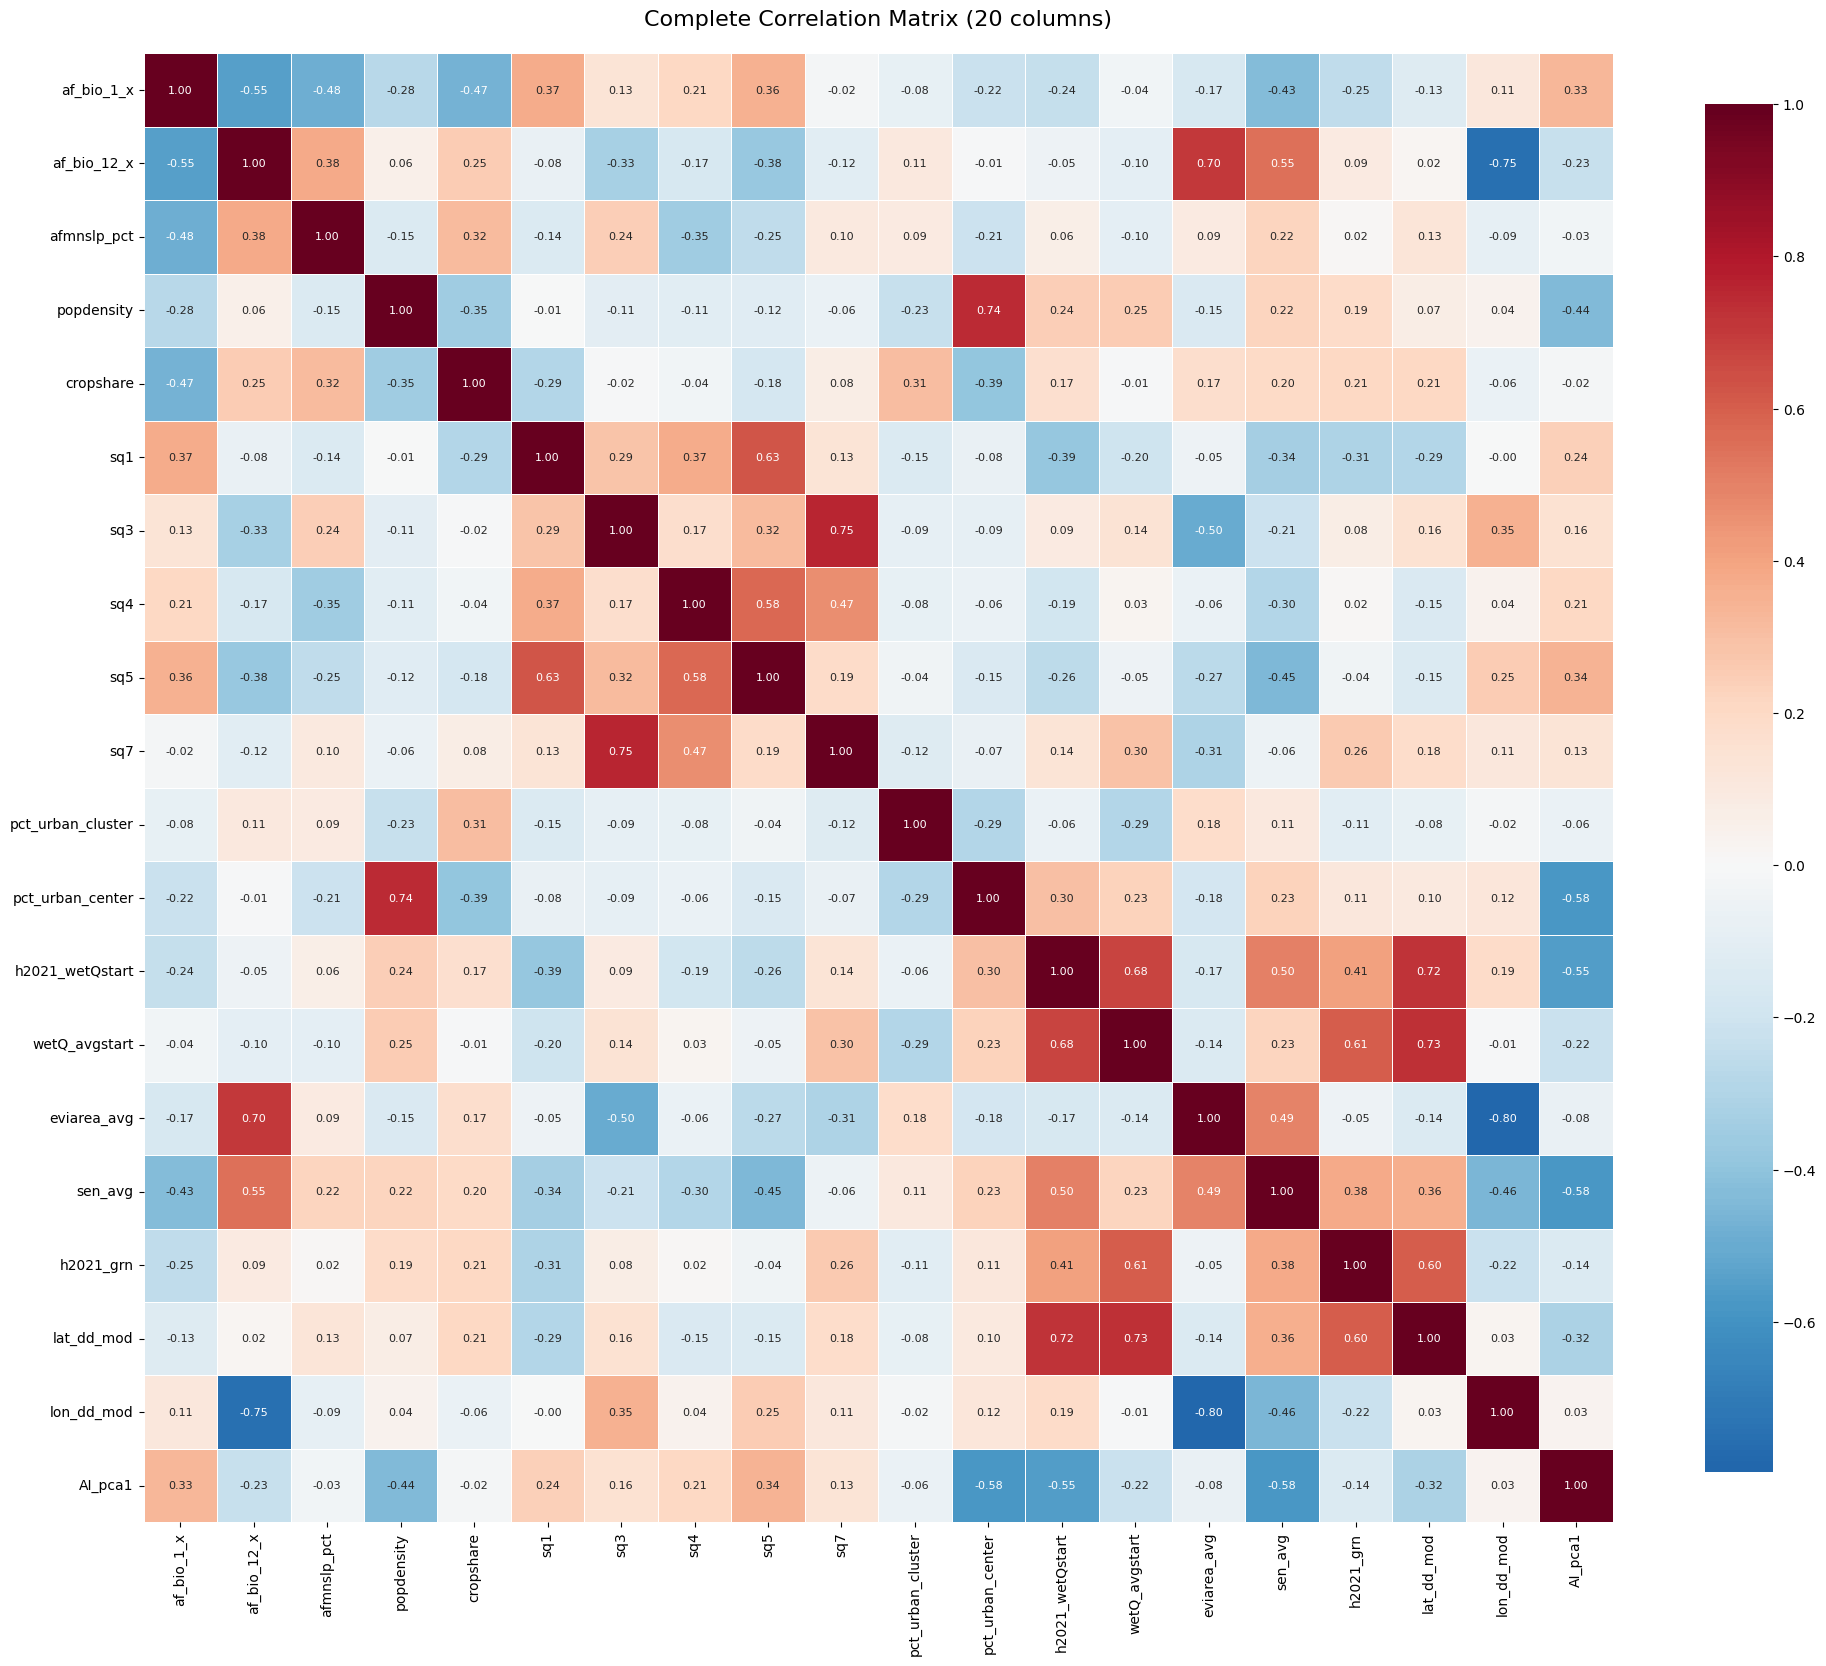


3. TARGET CORRELATION ANALYSIS
----------------------------------------

Top 10 features correlated with AI_pca1:
--------------------------------------------------
 1. sen_avg                        :  -0.583 (negative)
 2. pct_urban_center               :  -0.576 (negative)
 3. h2021_wetQstart                :  -0.553 (negative)
 4. popdensity                     :  -0.443 (negative)
 5. sq5                            :   0.342 (positive)
 6. af_bio_1_x                     :   0.329 (positive)
 7. lat_dd_mod                     :  -0.316 (negative)
 8. sq1                            :   0.239 (positive)
 9. af_bio_12_x                    :  -0.229 (negative)
10. wetQ_avgstart                  :  -0.216 (negative)


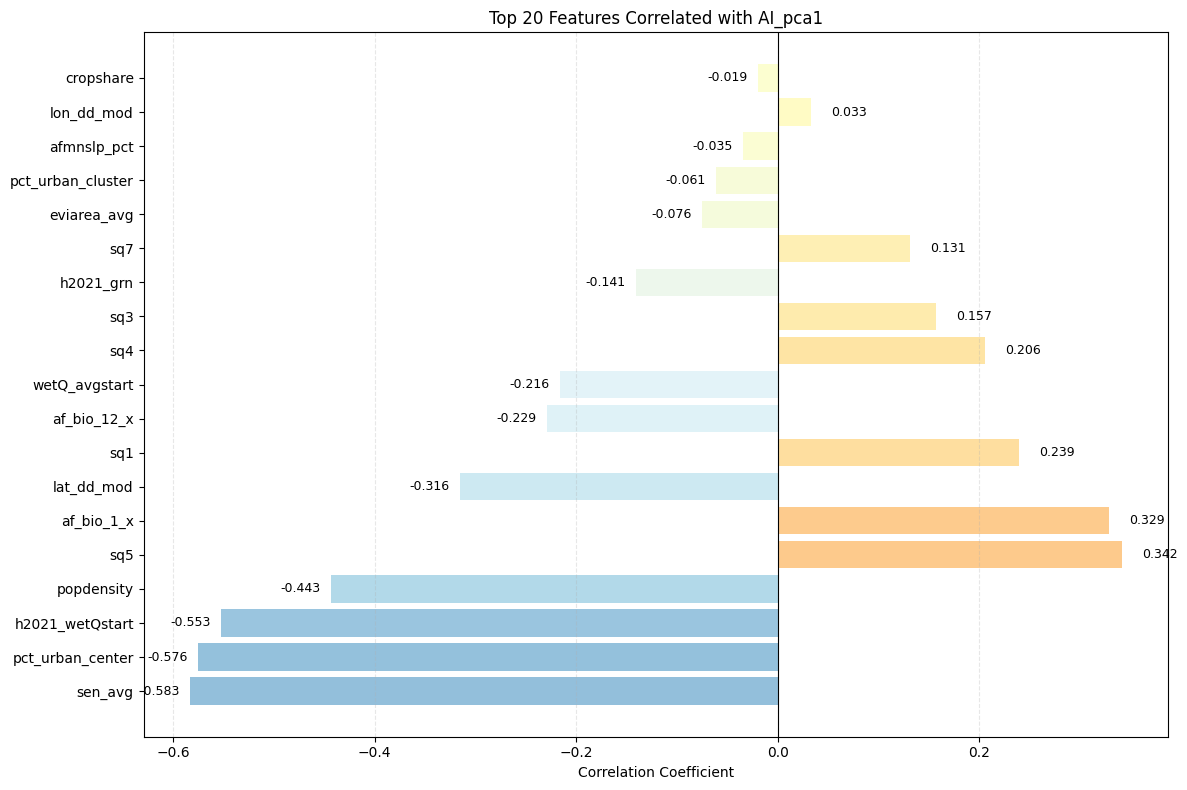


4. VIF ANALYSIS FOR ALL NUMERICAL FEATURES
----------------------------------------
Calculating VIF for 18 features...

VIF RESULTS SUMMARY:
------------------------------------------------------------
Feature                        VIF      Status      
------------------------------------------------------------
🟡 sq7                              6.16 MODERATE    
🟡 sq3                              5.92 MODERATE    
🟢 h2021_wetQstart                  4.75 OK          
🟢 sen_avg                          4.67 OK          
🟢 eviarea_avg                      4.39 OK          
🟢 af_bio_12_x                      4.32 OK          
🟢 wetQ_avgstart                    3.93 OK          
🟢 af_bio_1_x                       3.91 OK          
🟢 pct_urban_center                 3.89 OK          
🟢 sq4                              3.50 OK          
🟢 sq5                              3.47 OK          
🟢 AI_pca1                          2.97 OK          
🟢 sq1                              2.94 OK     

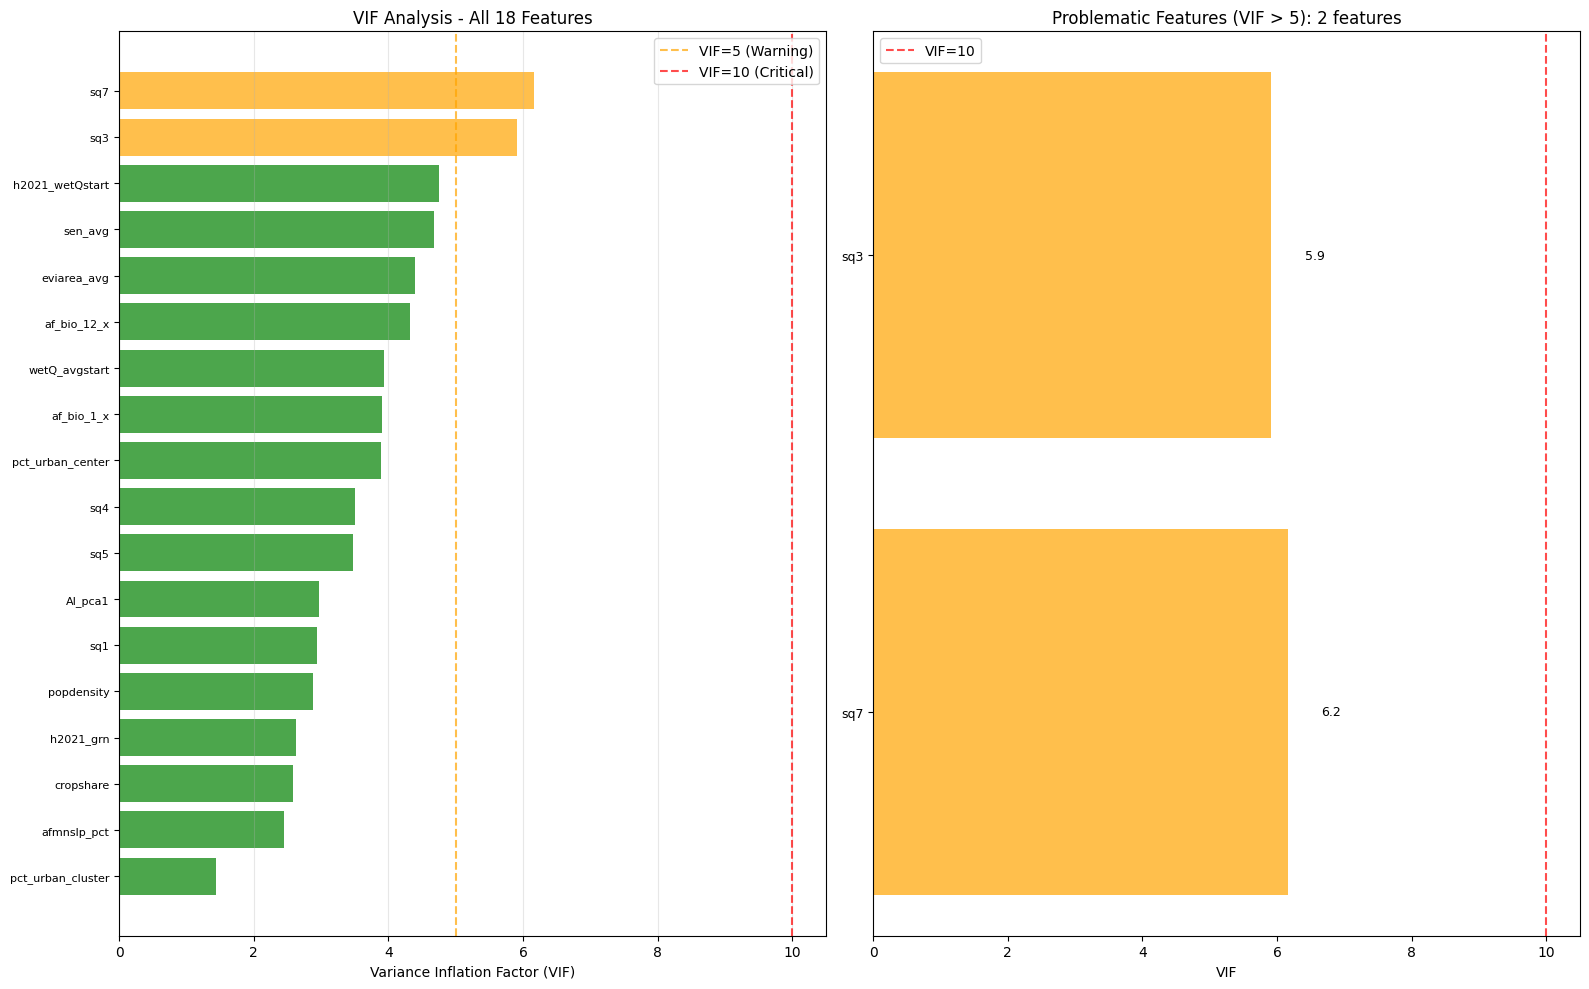


6. HIGHLY CORRELATED FEATURE PAIRS
----------------------------------------
No feature pairs found with |correlation| > 0.8

COMPREHENSIVE ANALYSIS SUMMARY

📊 SUMMARY STATISTICS:
  • Total columns analyzed: 20
  • Features with HIGH VIF (>10): 0
  • Features with MODERATE VIF (5-10): 2
  • Highly correlated pairs (|r| > 0.8): 0
  • Maximum VIF: 6.16
  • Average VIF: 3.71

🎯 TOP FEATURES FOR TARGET PREDICTION:
  • sen_avg: correlation = -0.583, VIF = 4.67
  • pct_urban_center: correlation = -0.576, VIF = 3.89
  • h2021_wetQstart: correlation = -0.553, VIF = 4.75

⚠️  RECOMMENDATIONS:
  ✓ No major multicollinearity issues detected!

ANALYSIS COMPLETE

Results stored in 'analysis_results' dictionary


In [62]:
# =============================================================================
# CORRELATION & VIF ANALYSIS - COMPLETE VERSION
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

print("\n" + "="*60)
print("COMPREHENSIVE CORRELATION AND VIF ANALYSIS")
print("="*60)

# =============================================================================
# 1. PREPARE DATA WITH ALL COLUMNS
# =============================================================================
print("\n1. PREPARING ALL DATA COLUMNS")
print("-"*40)

# Get ALL numerical columns from original dataframe
all_numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"Total numerical columns in df: {len(all_numerical_cols)}")

# Create DataFrame with ALL numerical columns + target
full_data = df[all_numerical_cols].copy()

# Make sure AI_pca1 is included (it's already in df from your preprocessing)
print(f"Including target column: AI_pca1")

# Display column count
print(f"\nAnalyzing {len(full_data.columns)} columns total:")

# =============================================================================
# 2. COMPREHENSIVE CORRELATION HEATMAP WITH NUMBERS
# =============================================================================
print("\n2. CORRELATION HEATMAP (WITH VALUES)")
print("-"*40)

# Calculate correlation matrix
corr_matrix = full_data.corr()

# Determine figure size based on number of columns
n_cols = len(corr_matrix.columns)
fig_width = max(20, n_cols * 0.7)
fig_height = max(18, n_cols * 0.6)

plt.figure(figsize=(fig_width, fig_height))

# Create heatmap with numbers
sns.heatmap(corr_matrix,
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            annot=True,  # Show numbers
            annot_kws={'size': 8},  # Font size for numbers
            fmt='.2f',  # Format numbers to 2 decimal places
            xticklabels=True,
            yticklabels=True)

plt.title(f'Complete Correlation Matrix ({n_cols} columns)', fontsize=16, pad=20)
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# =============================================================================
# 3. TARGET-SPECIFIC CORRELATION ANALYSIS
# =============================================================================
print("\n3. TARGET CORRELATION ANALYSIS")
print("-"*40)

# Find correlations with AI_pca1
if 'AI_pca1' in corr_matrix.columns:
    target_corrs = corr_matrix['AI_pca1'].drop('AI_pca1').sort_values(key=abs, ascending=False)

    print(f"\nTop 10 features correlated with AI_pca1:")
    print("-"*50)
    for i, (feat, corr) in enumerate(target_corrs.head(10).items(), 1):
        direction = "positive" if corr > 0 else "negative"
        print(f"{i:2}. {feat:30} : {corr:7.3f} ({direction})")

    # Plot top correlations
    plt.figure(figsize=(12, 8))
    top_20 = target_corrs.head(20)

    # Create color gradient
    colors = plt.cm.RdYlBu_r((top_20.values + 1) / 2)

    bars = plt.barh(range(len(top_20)), top_20.values, color=colors, alpha=0.8)
    plt.yticks(range(len(top_20)), top_20.index)
    plt.axvline(x=0, color='black', linewidth=0.8)
    plt.xlabel('Correlation Coefficient')
    plt.title('Top 20 Features Correlated with AI_pca1')
    plt.grid(axis='x', alpha=0.3, linestyle='--')

    # Add correlation values on bars
    for i, (bar, val) in enumerate(zip(bars, top_20.values)):
        x_pos = val + (0.02 if val >= 0 else -0.05)
        plt.text(x_pos, i, f'{val:.3f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# =============================================================================
# 4. VIF ANALYSIS FOR ALL NUMERICAL FEATURES
# =============================================================================
print("\n4. VIF ANALYSIS FOR ALL NUMERICAL FEATURES")
print("-"*40)

# Remove target column + spatial columns for VIF calculation Accessibility_Risk
exclude_cols = ['dist_road', 'lat_dd_mod', 'lon_dd_mod','accessibility_category','Accessibility_Risk',]
features_for_vif = [col for col in full_data.columns if col not in exclude_cols]
X_for_vif = full_data[features_for_vif].copy()

print(f"Calculating VIF for {len(X_for_vif.columns)} features...")

# Calculate VIF
def calculate_vif_safe(X_df, max_features=50):
    """Calculate VIF safely handling large datasets"""
    if len(X_df.columns) > max_features:
        print(f"  Note: Calculating VIF for {len(X_df.columns)} features may take time...")

    X_const = add_constant(X_df)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_const.columns

    vif_values = []
    for i in range(X_const.shape[1]):
        try:
            vif = variance_inflation_factor(X_const.values, i)
            vif_values.append(vif)
        except:
            vif_values.append(np.nan)

    vif_data["VIF"] = vif_values
    vif_data = vif_data[vif_data['feature'] != 'const']
    return vif_data.sort_values('VIF', ascending=False)

vif_results = calculate_vif_safe(X_for_vif)

print(f"\nVIF RESULTS SUMMARY:")
print("-"*60)
print(f"{'Feature':30} {'VIF':8} {'Status':12}")
print("-"*60)

# Display results with categorization
for _, row in vif_results.iterrows():
    vif_val = row['VIF']
    if pd.isna(vif_val):
        status = "ERROR"
        symbol = "?"
    elif vif_val > 10:
        status = "HIGH VIF"
        symbol = "🔴"
    elif vif_val > 5:
        status = "MODERATE"
        symbol = "🟡"
    else:
        status = "OK"
        symbol = "🟢"

    print(f"{symbol} {row['feature']:28} {vif_val:8.2f} {status:12}")

# =============================================================================
# 5. VIF VISUALIZATION
# =============================================================================
print("\n5. VIF VISUALIZATION")
print("-"*40)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Plot 1: All VIF values
vif_sorted = vif_results.sort_values('VIF')
axes[0].barh(range(len(vif_sorted)), vif_sorted['VIF'],
             color=['red' if v > 10 else 'orange' if v > 5 else 'green'
                    for v in vif_sorted['VIF']],
             alpha=0.7)
axes[0].set_yticks(range(len(vif_sorted)))
axes[0].set_yticklabels(vif_sorted['feature'], fontsize=8)
axes[0].axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='VIF=5 (Warning)')
axes[0].axvline(x=10, color='red', linestyle='--', alpha=0.7, label='VIF=10 (Critical)')
axes[0].set_xlabel('Variance Inflation Factor (VIF)')
axes[0].set_title(f'VIF Analysis - All {len(vif_sorted)} Features')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Problematic features only
problematic = vif_results[vif_results['VIF'] > 5]
if len(problematic) > 0:
    axes[1].barh(range(len(problematic)), problematic['VIF'],
                 color=['red' if v > 10 else 'orange' for v in problematic['VIF']],
                 alpha=0.7)
    axes[1].set_yticks(range(len(problematic)))
    axes[1].set_yticklabels(problematic['feature'], fontsize=9)
    axes[1].axvline(x=10, color='red', linestyle='--', alpha=0.7, label='VIF=10')
    axes[1].set_xlabel('VIF')
    axes[1].set_title(f'Problematic Features (VIF > 5): {len(problematic)} features')
    axes[1].legend()

    # Add VIF values on bars
    for i, (_, row) in enumerate(problematic.iterrows()):
        axes[1].text(row['VIF'] + 0.5, i, f'{row["VIF"]:.1f}',
                    va='center', fontsize=9)
else:
    axes[1].text(0.5, 0.5, 'No VIF issues!\nAll features have VIF < 5',
                ha='center', va='center', transform=axes[1].transAxes,
                fontsize=14, color='green')
    axes[1].set_title('No Multicollinearity Issues')

plt.tight_layout()
plt.show()

# =============================================================================
# 6. HIGHLY CORRELATED FEATURE PAIRS
# =============================================================================
print("\n6. HIGHLY CORRELATED FEATURE PAIRS")
print("-"*40)

threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            feat1, feat2 = corr_matrix.columns[i], corr_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_val))

if high_corr_pairs:
    print(f"Found {len(high_corr_pairs)} pairs with |correlation| > {threshold}:")
    print("-"*80)
    print(f"{'Feature 1':30} {'Feature 2':30} {'Correlation':12}")
    print("-"*80)

    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"{feat1:30} {feat2:30} {corr:12.3f}")
else:
    print(f"No feature pairs found with |correlation| > {threshold}")

# =============================================================================
# 7. COMPREHENSIVE SUMMARY
# =============================================================================
print("\n" + "="*60)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*60)

# Summary statistics
high_vif = vif_results[vif_results['VIF'] > 10]
moderate_vif = vif_results[(vif_results['VIF'] > 5) & (vif_results['VIF'] <= 10)]

print(f"\n📊 SUMMARY STATISTICS:")
print(f"  • Total columns analyzed: {len(full_data.columns)}")
print(f"  • Features with HIGH VIF (>10): {len(high_vif)}")
print(f"  • Features with MODERATE VIF (5-10): {len(moderate_vif)}")
print(f"  • Highly correlated pairs (|r| > 0.8): {len(high_corr_pairs)}")
print(f"  • Maximum VIF: {vif_results['VIF'].max():.2f}")
print(f"  • Average VIF: {vif_results['VIF'].mean():.2f}")

# Top correlations with target
if 'AI_pca1' in corr_matrix.columns:
    top_target_corr = target_corrs.head(3)
    print(f"\n🎯 TOP FEATURES FOR TARGET PREDICTION:")
    for feat, corr in top_target_corr.items():
        vif_val = vif_results[vif_results['feature'] == feat]['VIF'].values[0] if feat in vif_results['feature'].values else np.nan
        print(f"  • {feat}: correlation = {corr:.3f}, VIF = {vif_val:.2f}")

# Recommendations
print(f"\n⚠️  RECOMMENDATIONS:")
if len(high_vif) > 0:
    print(f"  1. Consider removing features with VIF > 10:")
    for _, row in high_vif.head(5).iterrows():
        print(f"     - {row['feature']} (VIF = {row['VIF']:.1f})")
if len(high_corr_pairs) > 0:
    print(f"  2. Check these highly correlated pairs for redundancy")
if len(high_vif) == 0 and len(high_corr_pairs) == 0:
    print("  ✓ No major multicollinearity issues detected!")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

# Store results for later use
analysis_results = {
    'correlation_matrix': corr_matrix,
    'vif_results': vif_results,
    'high_correlation_pairs': high_corr_pairs,
    'target_correlations': target_corrs if 'AI_pca1' in corr_matrix.columns else None
}

print("\nResults stored in 'analysis_results' dictionary")

In [61]:
to_drop = [
    'h2021_evimax', 'h2021_eviarea', 'h2021_tot', 'h2021_wetQ',
    'af_bio_8_x', 'af_bio_13_x', 'af_bio_16_x',
    'sq2', 'sq6','srtm_1k',
    'h2021_sen',
    'evimax_avg',
    'wetQ_avg',       # or anntot_avg — pick one
    'twi_ne','anntot_avg','grn_avg'
]

df_reduced = df.drop(columns=to_drop)
df=df_reduced.copy()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   af_bio_1_x                                  4890 non-null   int64  
 1   af_bio_12_x                                 4890 non-null   int64  
 2   afmnslp_pct                                 4890 non-null   int64  
 3   popdensity                                  4890 non-null   int64  
 4   cropshare                                   4890 non-null   int64  
 5   sq1                                         4890 non-null   int64  
 6   sq3                                         4890 non-null   int64  
 7   sq4                                         4890 non-null   int64  
 8   sq5                                         4890 non-null   int64  
 9   sq7                                         4890 non-null   int64  
 10  pct_urban_cl

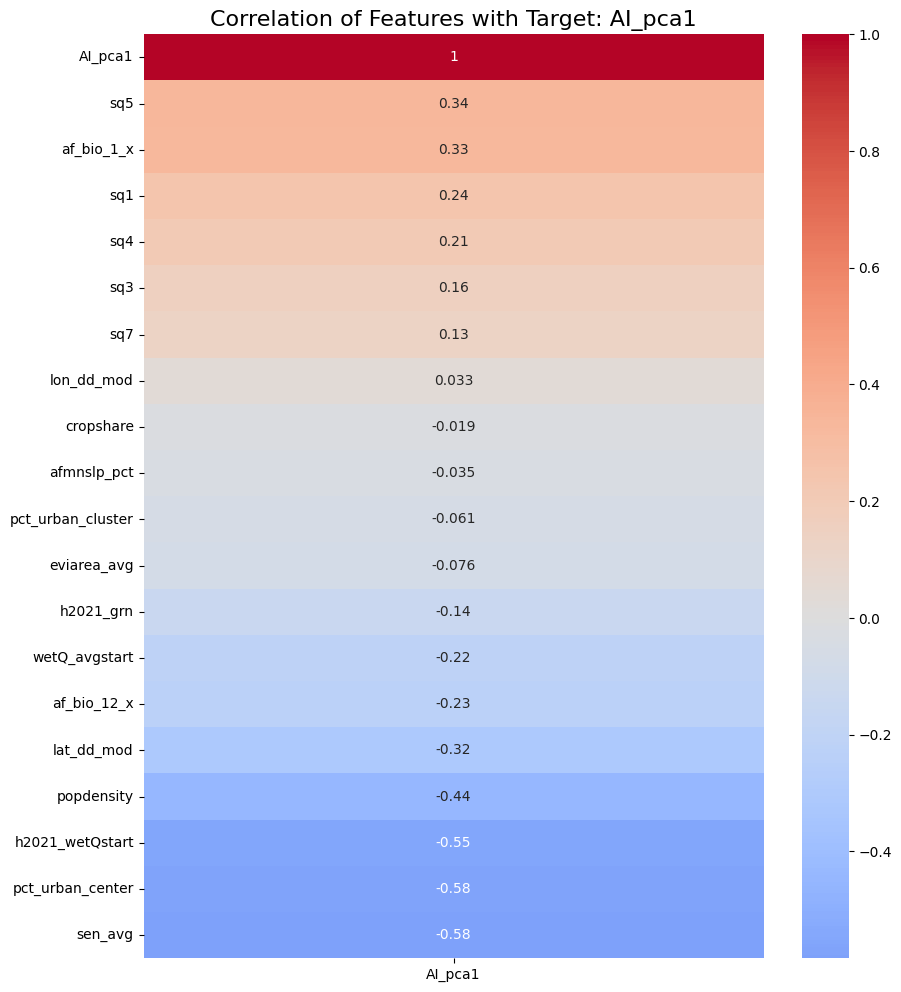

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your dataset with renamed columns

# Step 1: Choose target column
target = 'AI_pca1'

# Step 2: Select numeric columns only
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Step 3: Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Step 4: Focus on correlations with target
target_corr = corr_matrix[[target]].sort_values(by=target, ascending=False)

# Step 5: Plot heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation of Features with Target: {target}', fontsize=16)
plt.show()

In [13]:
# ===============================
# Define targets
# ===============================
y_reg = df['AI_pca1']                     # regression
y_cls = df['accessibility_category']      # classification

# ===============================
# Define features (remove targets)
# ===============================
X = df.drop(columns=['AI_pca1','accessibility_category','lat_dd_mod', 'lon_dd_mod'])

bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

In [ ]:
from sklearn.decomposition import PCA

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=0.95)  # retain 95% variance
X_reduced = pca.fit_transform(X_scaled)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

scaler = StandardScaler()

X_train_r = scaler.fit_transform(X_train_r)
X_test_r  = scaler.transform(X_test_r)

REGRESSION MODEL ANALYSIS

📊 Training 5 models...

COMPREHENSIVE MODEL PERFORMANCE
           Model  RMSE_Train  RMSE_Test  R2_Train  R2_Test
         XGBoost      0.0141     0.0575    0.9999   0.9987
        LightGBM      0.0191     0.0576    0.9999   0.9987
    RandomForest      0.0229     0.0581    0.9998   0.9987
LinearRegression      0.8506     0.8927    0.7102   0.6910
           Ridge      0.8507     0.8928    0.7102   0.6909

✅ Best Model: XGBoost
   Test R²: 0.9987
   Test RMSE: 0.0575
   Train R²: 0.9999
   Train RMSE: 0.0141

📈 Generating enhanced visualization...


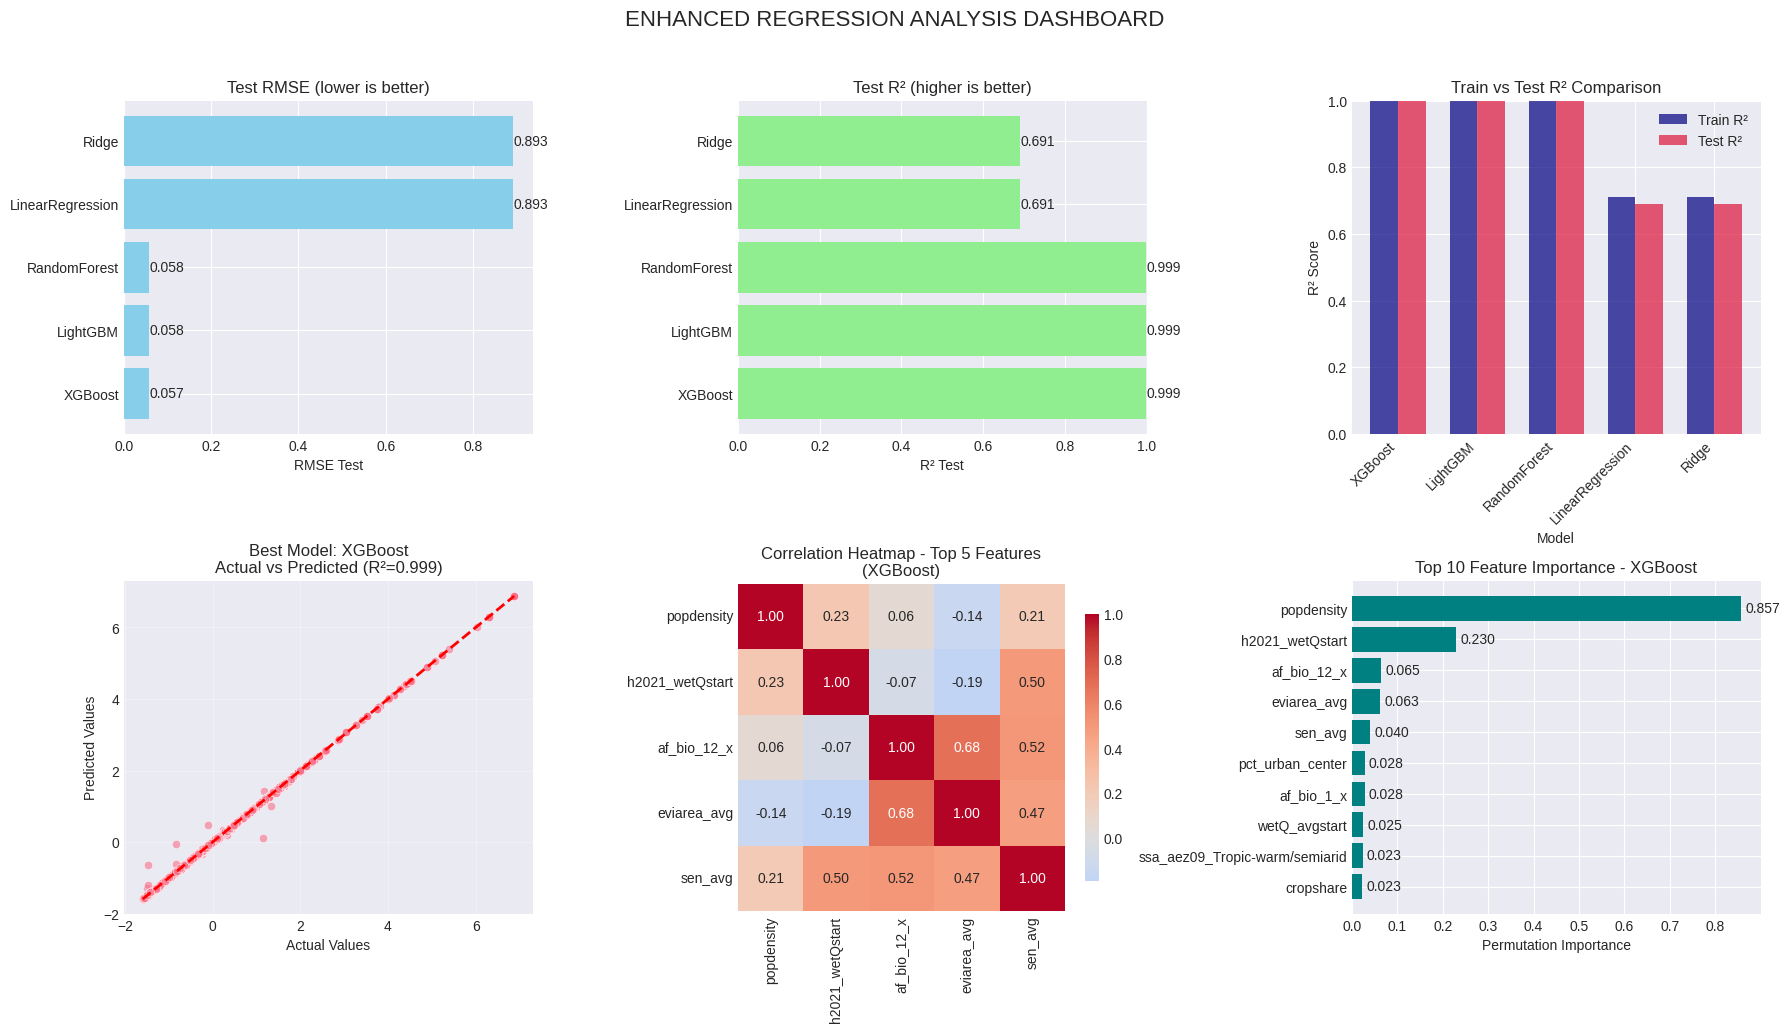


📊 Best Model Details:
Model          XGBoost
RMSE_Train    0.014069
RMSE_Test     0.057472
R2_Train      0.999921
R2_Test       0.998719
Name: 3, dtype: object

🔝 Top 8 Most Important Features:
             feature  importance
3         popdensity    0.857038
12   h2021_wetQstart    0.230103
1        af_bio_12_x    0.064859
14       eviarea_avg    0.062610
15           sen_avg    0.040180
11  pct_urban_center    0.028418
0         af_bio_1_x    0.028243
13     wetQ_avgstart    0.024695


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Optional imports
try:
    from xgboost import XGBRegressor
    xgb_available = True
except:
    xgb_available = False
try:
    from lightgbm import LGBMRegressor
    lgb_available = True
except:
    lgb_available = False

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def get_models():
    """Define regression models"""
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, min_samples_split=5)
    }
    if xgb_available:
        models["XGBoost"] = XGBRegressor(n_estimators=200, random_state=42, learning_rate=0.1, verbosity=0)
    if lgb_available:
        models["LightGBM"] = LGBMRegressor(n_estimators=200, random_state=42, learning_rate=0.1, verbose=-1)
    return models

def evaluate_models(models, X_train, X_test, y_train, y_test):
    """Train models and return comprehensive results with train/test metrics"""
    results, fitted, preds = [], {}, {}

    for name, model in models.items():
        model.fit(X_train, y_train)

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        preds[name] = y_pred_test

        # Calculate metrics
        results.append({
            "Model": name,
            "RMSE_Train": math.sqrt(mean_squared_error(y_train, y_pred_train)),
            "RMSE_Test": math.sqrt(mean_squared_error(y_test, y_pred_test)),
            "R2_Train": r2_score(y_train, y_pred_train),
            "R2_Test": r2_score(y_test, y_pred_test)
        })
        fitted[name] = model

    results_df = pd.DataFrame(results).sort_values("RMSE_Test")
    return results_df, fitted, preds

def plot_enhanced_results(results_df, y_test, predictions, feature_names, best_model, X_test):
    """Create enhanced comparison plots with requested features"""
    fig = plt.figure(figsize=(18, 10))

    # 1. Model Performance Comparison (2x2 grid)
    ax1 = plt.subplot(2, 3, 1)
    bars = ax1.barh(results_df['Model'], results_df['RMSE_Test'], color='skyblue')
    ax1.bar_label(bars, fmt='%.3f')
    ax1.set_xlabel('RMSE Test')
    ax1.set_title('Test RMSE (lower is better)')

    ax2 = plt.subplot(2, 3, 2)
    bars = ax2.barh(results_df['Model'], results_df['R2_Test'], color='lightgreen')
    ax2.bar_label(bars, fmt='%.3f')
    ax2.set_xlabel('R² Test')
    ax2.set_title('Test R² (higher is better)')
    ax2.set_xlim(0, 1)

    ax3 = plt.subplot(2, 3, 3)
    x = np.arange(len(results_df))
    width = 0.35
    ax3.bar(x - width/2, results_df['R2_Train'], width, label='Train R²', alpha=0.7, color='navy')
    ax3.bar(x + width/2, results_df['R2_Test'], width, label='Test R²', alpha=0.7, color='crimson')
    ax3.set_xlabel('Model')
    ax3.set_ylabel('R² Score')
    ax3.set_title('Train vs Test R² Comparison')
    ax3.set_xticks(x)
    ax3.set_xticklabels(results_df['Model'], rotation=45, ha='right')
    ax3.legend()
    ax3.set_ylim(0, 1)

    # 2. Actual vs Predicted for Best Model Only
    ax4 = plt.subplot(2, 3, 4)
    best_name = results_df.iloc[0]['Model']
    best_r2 = results_df.iloc[0]['R2_Test']
    ax4.scatter(y_test, predictions[best_name], alpha=0.6, edgecolors='w', linewidth=0.5)
    ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax4.set_xlabel('Actual Values')
    ax4.set_ylabel('Predicted Values')
    ax4.set_title(f'Best Model: {best_name}\nActual vs Predicted (R²={best_r2:.3f})')
    ax4.grid(True, alpha=0.3)

    # 3. Feature Correlation Heatmap (Top 5 features)
    ax5 = plt.subplot(2, 3, 5)

    # Get top 5 features from best model
    perm = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
    imp_df = pd.DataFrame({'feature': feature_names, 'importance': perm.importances_mean})
    top_5_features = imp_df.sort_values('importance', ascending=False).head(5)['feature'].tolist()

    # Create correlation matrix for top 5 features
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
    corr_matrix = X_test_df[top_5_features].corr()

    # Plot heatmap
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, ax=ax5, cbar_kws={"shrink": 0.8})
    ax5.set_title(f'Correlation Heatmap - Top 5 Features\n({best_name})')

    # 4. Feature Importance Ranking (Bar chart)
    ax6 = plt.subplot(2, 3, 6)
    top_10_features = imp_df.sort_values('importance', ascending=True).tail(10)
    bars = ax6.barh(top_10_features['feature'], top_10_features['importance'], color='teal')
    ax6.bar_label(bars, fmt='%.3f', padding=3)
    ax6.set_xlabel('Permutation Importance')
    ax6.set_title(f'Top 10 Feature Importance - {best_name}')

    plt.suptitle('ENHANCED REGRESSION ANALYSIS DASHBOARD', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    return imp_df.sort_values('importance', ascending=False)

def print_feature_importance_table(imp_df):

    # Try to display styled table in Jupyter
    try:
        from IPython.display import display
        styled_df = display_df.head(15).style.background_gradient(subset=['Importance'], cmap='YlOrRd')
        print("\n📊 Top 15 Features (Styled):")
        display(styled_df)
    except:
        pass

def run_analysis(X_train, X_test, y_train, y_test, feature_names):
    """Main execution function with enhanced outputs"""
    print("="*60)
    print("REGRESSION MODEL ANALYSIS")
    print("="*60)

    # Train models
    models = get_models()
    print(f"\n📊 Training {len(models)} models...")
    results_df, fitted_models, predictions = evaluate_models(models, X_train, X_test, y_train, y_test)

    # Display comprehensive results table
    print("\n" + "="*60)
    print("COMPREHENSIVE MODEL PERFORMANCE")
    print("="*60)
    print(results_df.round(4).to_string(index=False))

    # Identify best model
    best_name = results_df.iloc[0]['Model']
    best_model = fitted_models[best_name]
    print(f"\n✅ Best Model: {best_name}")
    print(f"   Test R²: {results_df.iloc[0]['R2_Test']:.4f}")
    print(f"   Test RMSE: {results_df.iloc[0]['RMSE_Test']:.4f}")
    print(f"   Train R²: {results_df.iloc[0]['R2_Train']:.4f}")
    print(f"   Train RMSE: {results_df.iloc[0]['RMSE_Train']:.4f}")

    # Enhanced visualization with all requested features
    print("\n📈 Generating enhanced visualization...")
    imp_df = plot_enhanced_results(
        results_df, y_test, predictions, feature_names,
        best_model, X_test
    )

    # Print detailed feature importance table
    print_feature_importance_table(imp_df)

    return results_df, fitted_models, predictions, imp_df

# ============================================================================
# USAGE EXAMPLE
# ============================================================================
# Uncomment and run with your data:

results, fitted_models, predictions, fi_df = run_analysis(
    X_train_r, X_test_r, y_train_r, y_test_r,
    feature_names=X.columns.tolist()  # Replace X with your feature DataFrame
)

# Access individual results
print("\n📊 Best Model Details:")
print(results.iloc[0])

print("\n🔝 Top 8 Most Important Features:")
print(fi_df.head(8))


#Classifcation Analysis for overall accessiblity


In [ ]:
from sklearn.preprocessing import StandardScaler
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

scaler = StandardScaler()

X_train_c = scaler.fit_transform(X_train_c)
X_test_c  = scaler.transform(X_test_c)


Training LogisticRegression...
 LogisticRegression Accuracy: 0.7924

              precision    recall  f1-score   support

        High     0.9489    0.9693    0.9590       326
         Low     0.7264    0.7242    0.7253       330
      Medium     0.6962    0.6832    0.6897       322

    accuracy                         0.7924       978
   macro avg     0.7905    0.7923    0.7913       978
weighted avg     0.7907    0.7924    0.7915       978

------------------------------------------------------------
Training RandomForest...
 RandomForest Accuracy: 0.9959

              precision    recall  f1-score   support

        High     0.9969    1.0000    0.9985       326
         Low     0.9970    0.9939    0.9954       330
      Medium     0.9938    0.9938    0.9938       322

    accuracy                         0.9959       978
   macro avg     0.9959    0.9959    0.9959       978
weighted avg     0.9959    0.9959    0.9959       978

---------------------------------------------------

,model,accuracy
1,RandomForest,0.995910
2,XGBoost,0.994888
0,LogisticRegression,0.792434


Best classifier: RandomForest


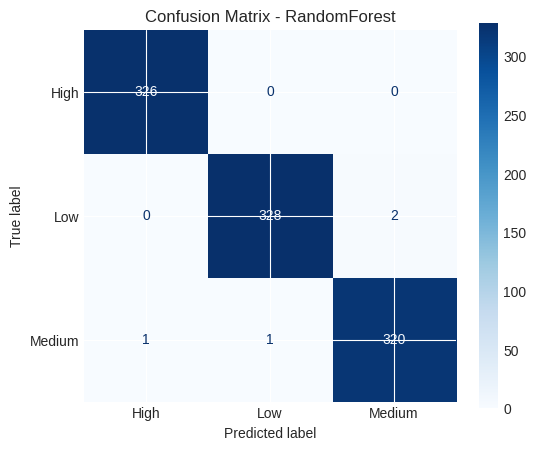

In [ ]:
# %% CELL 3 - CLASSIFICATION: TRAIN MODELS + METRICS + CONFUSION MATRIX
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix # Import accuracy_score and classification_report

# Optional model imports (XGBoost / LightGBM).
# These need to be imported within this cell's scope.
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

# Encode string labels if needed
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_c)
y_test_enc = le.transform(y_test_c)

# Define classifiers
models_clf = {
    "LogisticRegression": LogisticRegression(max_iter=200, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
}
if xgb_available:
    # Pass encoded numerical labels to XGBoost
    models_clf["XGBoost"] = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

fitted_clf = {}
results_clf = []

for name, model in models_clf.items():
    print(f"Training {name}...")
    # Use y_train_enc for XGBoost, otherwise use y_train_c
    if name == "XGBoost":
        model.fit(X_train_c, y_train_enc)
        preds = model.predict(X_test_c)
        acc = accuracy_score(y_test_enc, preds)
        clf_report = classification_report(y_test_enc, preds, target_names=le.classes_, digits=4)
    else:
        model.fit(X_train_c, y_train_c)
        preds = model.predict(X_test_c)
        acc = accuracy_score(y_test_c, preds)
        clf_report = classification_report(y_test_c, preds, target_names=le.classes_, digits=4)

    results_clf.append((name, acc))
    fitted_clf[name] = model
    print(f" {name} Accuracy: {acc:.4f}\n")
    print(clf_report)
    print("-"*60)

# Summary table
resclf_df = pd.DataFrame(results_clf, columns=["model", "accuracy"]).sort_values("accuracy", ascending=False)
# Using display for better rendering in Colab
from IPython.display import display
display(resclf_df)

# Confusion matrix for best classifier
best_clf_name = resclf_df.iloc[0]['model']
best_clf = fitted_clf[best_clf_name]
print("Best classifier:", best_clf_name)

# Ensure y_test_true is encoded for plotting if the best model is XGBoost
if best_clf_name == "XGBoost":
    y_pred_best = best_clf.predict(X_test_c)
    cm = confusion_matrix(y_test_enc, y_pred_best)
else:
    y_pred_best = best_clf.predict(X_test_c)
    cm = confusion_matrix(y_test_c, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - {best_clf_name}")
plt.show()


OVERFITTING CHECK + FEATURE IMPORTANCE
LogisticRegression  Train: 0.7932   Test: 0.7924   Gap: 0.0008
RandomForest        Train: 1.0000   Test: 0.9959   Gap: 0.0041
XGBoost             Train: 1.0000   Test: 0.9949   Gap: 0.0051

→ Large gap (>0.05–0.10) suggests overfitting

5-fold CV accuracy:
LogisticRegression  CV mean: 0.7937 ± 0.0183
RandomForest        CV mean: 0.9977 ± 0.0020
XGBoost             CV mean: 0.9967 ± 0.0022

Feature Importance (top 12):
          Feature  Importance
       popdensity     0.18358
 pct_urban_center     0.10372
      eviarea_avg     0.06899
      af_bio_12_x     0.06786
          sen_avg     0.06542
       af_bio_1_x     0.05771
        h2021_grn     0.05627
        cropshare     0.05313
  h2021_wetQstart     0.05134
 landcov_Built-up     0.04808
      afmnslp_pct     0.04249
pct_urban_cluster     0.04053


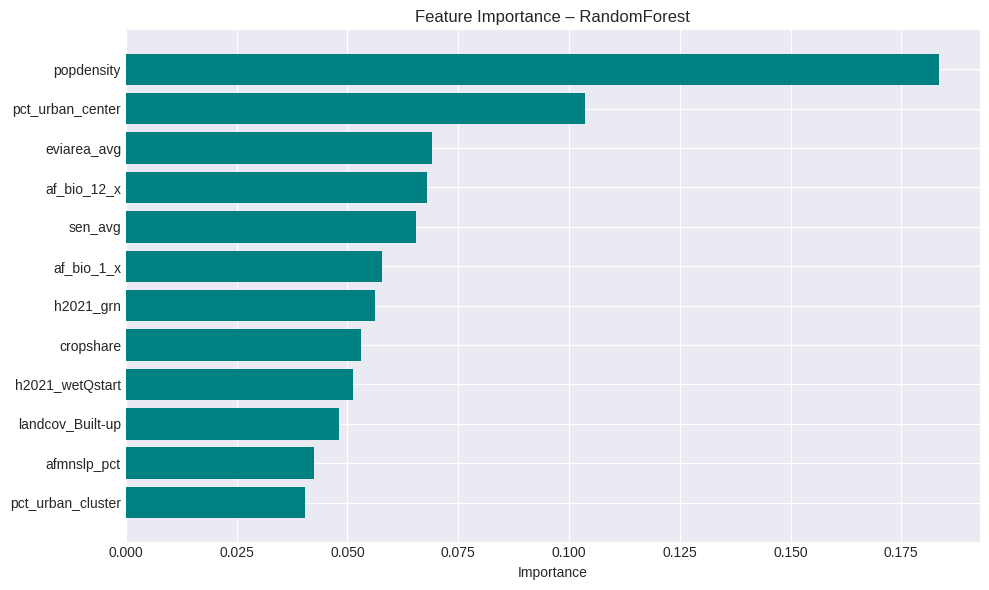

In [ ]:
# ============================================================================
# OVERFITTING CHECK + FEATURE IMPORTANCE
# ============================================================================

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd # Import pandas for DataFrame operations

print("\n" + "="*50)
print("OVERFITTING CHECK + FEATURE IMPORTANCE")
print("="*50)

# 1. Train vs Test gap (simple overfitting indicator)
for name, model in fitted_clf.items():
    if name == "XGBoost":
        train_pred = model.predict(X_train_c)
        test_pred  = model.predict(X_test_c)
        train_acc = accuracy_score(y_train_enc, train_pred)
        test_acc  = accuracy_score(y_test_enc, test_pred)
    else:
        train_pred = model.predict(X_train_c)
        test_pred  = model.predict(X_test_c)
        train_acc = accuracy_score(y_train_c, train_pred)
        test_acc  = accuracy_score(y_test_c, test_pred)

    gap = train_acc - test_acc
    print(f"{name:18}  Train: {train_acc:.4f}   Test: {test_acc:.4f}   Gap: {gap:.4f}")

print("\n→ Large gap (>0.05–0.10) suggests overfitting")

# 2. 5-fold cross-validation score (more reliable generalization estimate)
print("\n5-fold CV accuracy:")
for name, model in fitted_clf.items():
    if name == "XGBoost":
        scores = cross_val_score(model, X_train_c, y_train_enc, cv=5, scoring='accuracy', n_jobs=-1)
    else:
        scores = cross_val_score(model, X_train_c, y_train_c, cv=5, scoring='accuracy', n_jobs=-1)
    print(f"{name:18}  CV mean: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# 3. Feature importance (only RandomForest and XGBoost support it natively)
print("\nFeature Importance (top 12):")
best_model = fitted_clf[best_clf_name]

if best_clf_name in ["RandomForest", "XGBoost"]:
    if best_clf_name == "RandomForest":
        imp = best_model.feature_importances_
    else:  # XGBoost
        imp = best_model.feature_importances_

    idx = np.argsort(imp)[::-1]
    top_features = pd.DataFrame({
        'Feature': X.columns[idx][:12], # Use X.columns instead of X_train_c.columns
        'Importance': imp[idx][:12]
    })

    print(top_features.round(5).to_string(index=False))

    # Bar plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='teal')
    plt.title(f"Feature Importance – {best_clf_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

else:
    print("→ LogisticRegression has no built-in feature importance.")
    print("   Use permutation importance instead if needed.")

In [ ]:
# %% CELL 4 — SPATIAL MAP OF ACCESSIBILITY CLASSIFICATION

import geopandas as gpd
import folium
from folium.plugins import MarkerCluster, HeatMap
import pandas as pd # Ensure pandas is imported if not already globally

# -------------------------------------------------------
# 1. GET PREDICTIONS FROM BEST MODEL
# -------------------------------------------------------

# If best model is XGBoost → labels encoded
if best_clf_name == "XGBoost":
    preds = best_clf.predict(X_test_c)
    preds = le.inverse_transform(preds)
else:
    preds = best_clf.predict(X_test_c)

# -------------------------------------------------------
# 2. CREATE RESULTS DATAFRAME
# -------------------------------------------------------

# Create map_df as a DataFrame using the scaled X_test_c values,
# but use the index from y_test_c to ensure correct alignment with original data.
# X.columns are used to provide column names as X_test_c is an array.
map_df = pd.DataFrame(X_test_c, columns=X.columns, index=y_test_c.index)

map_df["Actual"] = y_test_c.values
map_df["Predicted"] = preds

# attach coordinates from original dataframe
# Use the 'original_df_for_coords' which should have been saved in a previous step
# to retain lat_dd_mod and lon_dd_mod.
# This assumes `original_df_for_coords` contains the original full dataframe (including lat/lon) before dropping.
map_df["lat"] = df.loc[map_df.index, "lat_dd_mod"]
map_df["lon"] = df.loc[map_df.index, "lon_dd_mod"]

# drop missing coords
map_df = map_df.dropna(subset=["lat","lon"])

print("Points mapped:", len(map_df))

# -------------------------------------------------------
# 3. CONVERT TO GEODATAFRAME
# -------------------------------------------------------

gdf = gpd.GeoDataFrame(
    map_df,
    geometry=gpd.points_from_xy(map_df.lon, map_df.lat),
    crs="EPSG:4326"
)

# -------------------------------------------------------
# 4. CREATE INTERACTIVE MAP
# -------------------------------------------------------

m = folium.Map(
    location=[gdf.lat.mean(), gdf.lon.mean()],
    zoom_start=6,
    tiles="cartodbpositron"
)

marker_cluster = MarkerCluster().add_to(m)

# color scheme (edit class names if different)
color_map = {
    "Low": "red",
    "Medium": "orange",
    "High": "green"
}

# -------------------------------------------------------
# 5. ADD MARKERS
# -------------------------------------------------------

for _, row in gdf.iterrows():
    folium.Marker(
        location=[row.lat, row.lon],
        popup=f"""
        <b>Predicted:</b> {row.Predicted}<br>
        <b>Actual:</b> {row.Actual}
        """,
        icon=folium.Icon(color=color_map.get(row.Predicted, "blue"))
    ).add_to(marker_cluster)

# -------------------------------------------------------
# 6. HEATMAP FOR LOW ACCESSIBILITY (optional)
# -------------------------------------------------------

low_points = gdf[gdf["Predicted"] == "Low"][["lat","lon"]].values.tolist()

if len(low_points) > 0:
    HeatMap(low_points, radius=10, name="Low Accessibility").add_to(m)

# -------------------------------------------------------
# 7. LEGEND
# -------------------------------------------------------

legend_html = """
<div style="
position: fixed;
bottom: 40px;
left: 40px;
width: 180px;
background-color: white;
border:2px solid grey;
z-index:9999;
font-size:14px;
padding: 10px;
">
<b>Accessibility Level</b><br>
<i style="color:red">●</i> Low<br>
<i style="color:orange">●</i> Medium<br>
<i style="color:green">●</i> High
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

folium.LayerControl().add_to(m)

m

Points mapped: 969


In [15]:
# ==========================================================
# STEP 1: SELECT VARIABLES FOR RISK INDEX
# ==========================================================

risk_vars = [
    'dist_road',      # remoteness
    'dist_market',    # service access
    'afmnslp_pct',  # slop or terrain difficulty
    'popdensity',  # service pressure
    'pct_urban_center'     # rural isolation indicator
]

# keep only available columns
risk_vars = [col for col in risk_vars if col in df.columns]

print("Variables used:", risk_vars)

# ==========================================================
# STEP 2: NORMALIZE (0–1 SCALE)
# ==========================================================

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

norm_data = scaler.fit_transform(df[risk_vars])
norm_df = pd.DataFrame(norm_data, columns=[v + "_norm" for v in risk_vars])

df = pd.concat([df, norm_df], axis=1)

print("Normalization complete ✓")

# ==========================================================
# STEP 3: ACCESSIBILITY RISK SCORE
# ==========================================================

df['Accessibility_Risk'] = (
    0.35 * df['dist_road_norm'] +
    0.25 * df['dist_market_norm'] +
    0.20 * df['terrain_slope_norm'] +
    0.20 * (1 - df['urban_index_norm'])   # less urban = higher risk
)

print("Risk score created ✓")
df['Accessibility_Risk'].describe()

# ==========================================================
# STEP 4: CLASSIFY RISK LEVELS
# ==========================================================

q1 = df['Accessibility_Risk'].quantile(0.33)
q2 = df['Accessibility_Risk'].quantile(0.66)

def classify_risk(x):
    if x <= q1:
        return "Low Risk"
    elif x <= q2:
        return "Moderate Risk"
    else:
        return "High Risk"

df['Risk_Class'] = df['Accessibility_Risk'].apply(classify_risk)

print(df['Risk_Class'].value_counts())

Variables used: ['afmnslp_pct', 'popdensity', 'pct_urban_center']


In [16]:
# ==========================================================
# STEP 2: NORMALIZE (0–1 SCALE)
# ==========================================================

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

norm_data = scaler.fit_transform(df[risk_vars])
norm_df = pd.DataFrame(norm_data, columns=[v + "_norm" for v in risk_vars])

df = pd.concat([df, norm_df], axis=1)

print("Normalization complete ✓")

Normalization complete ✓


In [17]:
# ==========================================================
# STEP 3: ACCESSIBILITY RISK SCORE
# ==========================================================

df['Accessibility_Risk'] = (
    0.35 * df['dist_road_norm'] +
    0.25 * df['dist_market_norm'] +
    0.20 * df['terrain_slope_norm'] +
    0.20 * (1 - df['urban_index_norm'])   # less urban = higher risk
)

print("Risk score created ✓")
df['Accessibility_Risk'].describe()

KeyError: 'dist_road_norm'

In [ ]:
# ==========================================================
# STEP 4: CLASSIFY RISK LEVELS
# ==========================================================

q1 = df['Accessibility_Risk'].quantile(0.33)
q2 = df['Accessibility_Risk'].quantile(0.66)

def classify_risk(x):
    if x <= q1:
        return "Low Risk"
    elif x <= q2:
        return "Moderate Risk"
    else:
        return "High Risk"

df['Risk_Class'] = df['Accessibility_Risk'].apply(classify_risk)

print(df['Risk_Class'].value_counts())